In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 512
latent_dim = 16
n_embeddings= 512
output_dim = 3
commitment_beta = 0.25

lr = 2e-4

epochs = 50

print_step = 50

In [3]:
torch.cuda.is_available()

True

###    Step 1. Load (or download) Dataset

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

100%|██████████| 170498071/170498071 [00:04<00:00, 37608953.08it/s]


Extracting /root/datasets/cifar-10-python.tar.gz to /root/datasets
Files already downloaded and verified


### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [5]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()

        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size

        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)

        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)

        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)

    def forward(self, x):

        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)

        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x

        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x

        y = self.proj(y)
        return y

In [6]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))

    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)

        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [7]:
class Decoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()

        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes

        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)

        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)

        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)

    def forward(self, x):

        x = self.in_proj(x)

        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)

        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)

        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)

        return y

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder

    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)

        return x_hat, commitment_loss, codebook_loss, perplexity

In [9]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [11]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)

        loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss

        loss.backward()
        optimizer.step()

        if batch_idx % print_step ==0:
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(),
              " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")

print("Finish!!")

Start training VQ-VAE...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 1 ( 1 ) recon_loss: 0.352276086807251  perplexity:  31.633440017700195  commit_loss:  0.0019343305611982942 
	 codebook loss:  0.007737322244793177  total_loss:  0.36049696803092957 

epoch: 1 ( 51 ) recon_loss: 0.02319476753473282  perplexity:  131.04124450683594  commit_loss:  0.03637251630425453 
	 codebook loss:  0.14549006521701813  total_loss:  0.177777960896492 

epoch: 1 ( 101 ) recon_loss: 0.017020490020513535  perplexity:  188.10440063476562  commit_loss:  0.033105745911598206 
	 codebook loss:  0.13242298364639282  total_loss:  0.1577199101448059 

epoch: 1 ( 151 ) recon_loss: 0.013440221548080444  perplexity:  230.0946807861328  commit_loss:  0.02616818994283676 
	 codebook loss:  0.10467275977134705  total_loss:  0.12465503066778183 

epoch: 1 ( 201 ) recon_loss: 0.010788711719214916  perplexity:  276.90142822265625  commit_loss:  0.025009535253047943 
	 codebook loss:  0.10003814101219177  total_loss:  0.1170792356133461 

epoch: 1 ( 251 ) recon_loss: 0.01000793091

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 2 ( 1 ) recon_loss: 0.009250674396753311  perplexity:  359.7452087402344  commit_loss:  0.028631072491407394 
	 codebook loss:  0.11452428996562958  total_loss:  0.1309327334165573 

epoch: 2 ( 51 ) recon_loss: 0.00862254947423935  perplexity:  349.8041076660156  commit_loss:  0.026918895542621613 
	 codebook loss:  0.10767558217048645  total_loss:  0.12302785366773605 

epoch: 2 ( 101 ) recon_loss: 0.008314033038914204  perplexity:  364.0802001953125  commit_loss:  0.02670474909245968 
	 codebook loss:  0.10681899636983871  total_loss:  0.1218092143535614 

epoch: 2 ( 151 ) recon_loss: 0.00806600321084261  perplexity:  355.4024963378906  commit_loss:  0.02677745744585991 
	 codebook loss:  0.10710982978343964  total_loss:  0.12187019735574722 

epoch: 2 ( 201 ) recon_loss: 0.008390390314161777  perplexity:  372.8694763183594  commit_loss:  0.027567261829972267 
	 codebook loss:  0.11026904731988907  total_loss:  0.1255512535572052 

epoch: 2 ( 251 ) recon_loss: 0.00726423179730

### Step 5. Evaluate the model

In [12]:
import matplotlib.pyplot as plt

In [13]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [23]:
model.eval()

ground_truth_images = []
generated_images = []

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)

        # Assuming x_hat is already in the range [0, 1], if not, adjust accordingly
        # Resize and normalize for Inception v3
        resize_transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        x = resize_transform(x)
        x_hat = resize_transform(x_hat)

        generated_images.append(x_hat.cpu())
        ground_truth_images.append(x.cpu())

        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

# Concatenate all collected images into a single tensor
generated_images = torch.cat(generated_images, dim=0)
ground_truth_images = torch.cat(ground_truth_images, dim=0)

  0%|          | 0/79 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  417.593994140625 commit_loss:  0.022632058709859848   codebook loss:  0.09052823483943939


In [24]:
import torch
import torchvision.transforms as transforms
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images.

    imgs: Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda: If True, use GPU
    batch_size: Batch size for feeding into Inception v3
    resize: If True, resize images to (299, 299) as required by Inception v3
    splits: Number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dataloader
    dataloader = DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    if cuda:
        inception_model.cuda()

    # Get prediction probabilities
    def get_preds(x):
        if resize:
            x = transforms.functional.resize(x, (299, 299))
        if cuda:
            x = x.cuda()
        x = inception_model(x)
        return torch.nn.functional.softmax(x, dim=1).detach().cpu().numpy()

    # Calculate scores
    preds = np.concatenate([get_preds(batch) for batch in dataloader], axis=0)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        p_y = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            p_yx = part[i, :]
            scores.append(entropy(p_yx, p_y))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Compute the Inception Score
mean_is, std_is = inception_score(generated_images, cuda=True, batch_size=32, resize=False, splits=10)

print(f"Inception Score: {mean_is:.2f} ± {std_is:.2f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 3.13 ± 0.38


In [27]:
import torch
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def get_inception_features(images, model, batch_size, device):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in DataLoader(images, batch_size=batch_size):
            batch = batch.to(device)
            feat = model(batch)
            features.append(feat.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

def calculate_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True)
inception_model.fc = torch.nn.Identity()
inception_model.to(device)

real_features = get_inception_features(ground_truth_images, inception_model, batch_size=50, device=device)
fake_features = get_inception_features(generated_images, inception_model, batch_size=50, device=device)
fid_score = calculate_fid(real_features, fake_features)
print("FID Score:", fid_score)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID Score: 1.8649621365367e+87


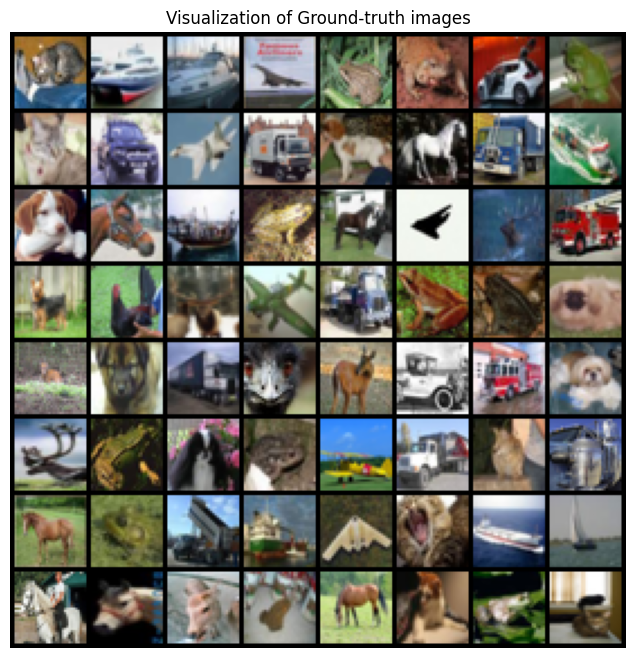

In [16]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

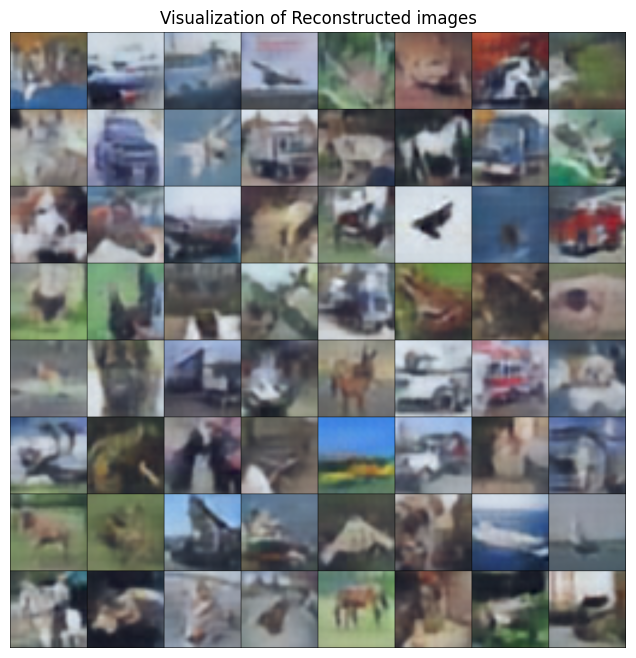

In [18]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

### Step 6. Generate samples via random codes

In [19]:
def draw_random_sample_image(codebook, decoder, indices_shape):

    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

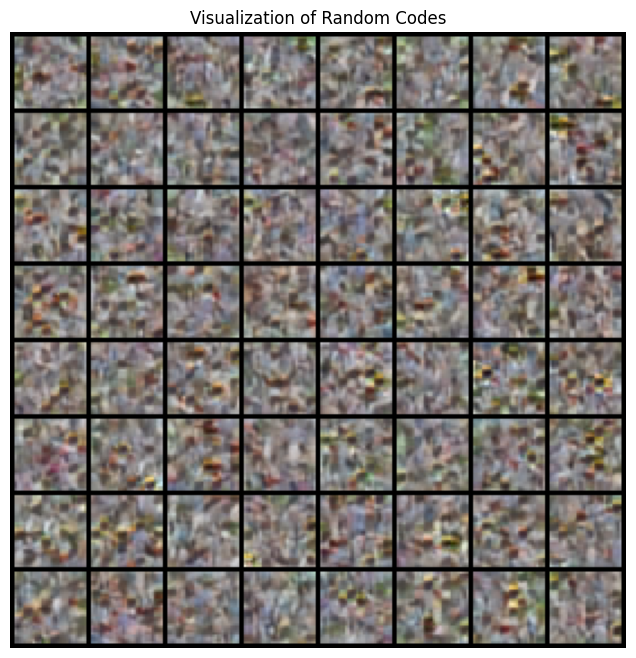

In [20]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8, 8))